# Imports and necessary loads

In [1]:
%matplotlib inline
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime 

import tensorflow as tf
import keras.backend as K

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from keras.utils import Sequence
from keras.utils import load_img
from keras.optimizers import RMSprop
from keras.optimizers import Adam

2023-01-28 01:54:37.740461: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('black_background_500x500.csv')
train_df = df[df['ImagePath'].str.contains("train")]
test_df = df[df['ImagePath'].str.contains("test")]
valid_df = df[df['ImagePath'].str.contains("valid")]

input_size = 500

# Functions

In [3]:
############# Loss Functions #############
def abs_loss_function(y_true, y_pred):   
    abs_diff = K.abs(y_true - y_pred)
    ones = tf.ones_like(y_true)
    abs_diff_reversed = K.abs(ones - abs_diff )   
    minimum_from_two = tf.math.minimum(abs_diff, abs_diff_reversed) 
    return tf.math.reduce_mean(minimum_from_two, axis=-1)

def square_abs_min_loss(y_true, y_pred):   
    abs_diff = K.abs(y_true - y_pred)
    ones = tf.ones_like(y_true)
    abs_diff_reversed = K.abs(tf.ones_like(y_true) - abs_diff )   
    minimum_from_two = tf.math.minimum(abs_diff, abs_diff_reversed) 
    min_sq = tf.math.sqrt(minimum_from_two)
    return tf.math.reduce_mean(min_sq, axis=-1) 

def smart_square_abs_min_loss(y_true, y_pred):  
    punished_y_pred = tf.where((y_pred<0)|(y_pred>1), 3.0 + K.abs(y_pred),y_pred)
    
    abs_diff = K.abs(y_true - punished_y_pred)
    ones = tf.ones_like(y_true)
    abs_diff_reversed = K.abs(ones - abs_diff)   
    minimum_from_two = tf.math.minimum(abs_diff, abs_diff_reversed) 

############# Plotting the graph function #############
def plot_accuracy_loss(history):
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'],'ro--', label = "val_accuracy")
    plt.plot(accuracy_list,'go--', label = "eval_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'],'ro--', label = "val_loss")
    plt.plot(evaluation_list,'go--', label = "eval_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()

# Dataloader

In [4]:
class datagenerator(tf.keras.utils.Sequence):
    def __init__(self, 
            batch_size, 
            img_size,
            data_paths_df,
            input_channels,
            output_channels):
         
        self.batch_size = batch_size
        self.img_size = img_size
        self.data_paths_df = data_paths_df
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.data_paths = data_paths_df.values[:,1]
        self.params = data_paths_df.values[:,3:6]
        assert len(self.data_paths) == len(self.params)
        
        self.n = len(self.data_paths)

    def on_epoch_end(self):
        'updates indexes after each epoch'
        self.data_paths_df = self.data_paths_df.sample(frac = 1)
        self.data_paths = self.data_paths_df.values[:,1]
        self.params = self.data_paths_df.values[:,3:6]
    
    def __getitem__(self, index):
        batch_data_paths = self.data_paths[index : index + self.batch_size]
        batch_params_paths = self.params[index : index + self.batch_size]

        return self.__dataloader(self.img_size,
                batch_data_paths, batch_params_paths,
                self.input_channels, self.output_channels)
    
    def __len__(self):
        return self.n // self.batch_size

    #################### data loader ########################
    def __dataloader(self, 
            img_size,
            data_paths,
            batch_params_paths,
            input_channels,
            output_channels):
        x = np.zeros((len(data_paths), img_size[0], img_size[1], input_channels))
        y = batch_params_paths        
        
        for i in range(len(data_paths)):
            data = load_img(path = data_paths[i], color_mode = "grayscale")
            data = tf.keras.utils.img_to_array(data, data_format="channels_last", dtype="float32")
            data /= 255
            data.shape = (1,) + data.shape
            x[i] = np.asarray(data)
        return x.astype("float32"), np.array(y).astype("float32")

# Callback function

In [13]:
test_g = datagenerator(32, (input_size,input_size), test_df, 1, 3)
evaluation_list = []
accuracy_list = []
class LossHistory(keras.callbacks.Callback):
    evaluation_list = []
    accuracy_list = []
    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0:
            print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
            m_e = self.model.evaluate(test_g, batch_size=32)
            for i in range(10):
                evaluation_list.append(m_e[0])
                accuracy_list.append(m_e[2])
            print("Loss on test data: ", m_e[0])
            for nr in range(3):
                t = test_df.values[nr][1]
                data = load_img(path = t, grayscale = True)
                data = tf.keras.utils.img_to_array(data, data_format="channels_last", dtype="float32")
                data /= 255
                data.shape = (1,) + data.shape
                X = np.asarray(data)
                print("----------{}----------".format(nr))
                euler = t.split("_")
                print("phi1", float(euler[3]))
                print("PHI",   float(euler[4]))
                print("phi2",  float(euler[5][:-4]))
                yhat = model.predict(data)
                print("predicted values", yhat*90)
            print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

# First model 

In [15]:
inputs = keras.Input(shape=(input_size, input_size, 1))
x = layers.Conv2D(filters=4, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=4, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=4, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
output = layers.Dense(3, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=output)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 500, 500, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 498, 498, 4)       40        
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 249, 249, 4)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 247, 247, 4)       148       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 123, 123, 4)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 121, 121, 4)       148 

# Running the model

In [16]:
model.compile(optimizer = "sgd",
              loss=abs_loss_function, 
              metrics = [abs_loss_function, "accuracy"],
              run_eagerly=True)  # Add run_eagerly=True to enable the numpy debugging

tg = datagenerator(32, (input_size,input_size), train_df, 1, 3)
vg = datagenerator(32, (input_size,input_size), valid_df, 1, 3)
history = model.fit(x=tg,
                    batch_size=32,
                    epochs=100,
                    validation_data=vg,
                    callbacks=[LossHistory()])

Epoch 1/100
31/31 [==============================] - 7s 218ms/step - loss: 0.2542 - abs_loss_function: 0.2542 - accuracy: 0.3317
Loss on test data:  0.25424689054489136
----------0----------
phi1 54.7
PHI 36.1
phi2 23.5
1/1 [==============================] - 0s 25ms/step
predicted values [[44.840824  84.73089    7.8859987]]
----------1----------
phi1 76.0
PHI 83.7
phi2 2.9
1/1 [==============================] - 0s 21ms/step
predicted values [[44.67386  81.38278  11.688713]]
----------2----------
phi1 17.8
PHI 63.8
phi2 50.8
1/1 [==============================] - 0s 20ms/step
predicted values [[44.44299  84.94922   7.622348]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
273/273 [==============================] - 81s 296ms/step - loss: 0.2418 - abs_loss_function: 0.2418 - accuracy: 0.3951 - val_loss: 0.2680 - val_abs_loss_function: 0.2680 - val_accuracy: 0.3518
Epoch 2/100
273/273 [==============================] - 74s 270ms/step - loss: 0.2434 - abs_loss_function: 0.2434 - 

Epoch 28/100
273/273 [==============================] - 74s 271ms/step - loss: 0.2447 - abs_loss_function: 0.2447 - accuracy: 0.3618 - val_loss: 0.2471 - val_abs_loss_function: 0.2471 - val_accuracy: 0.2702
Epoch 29/100
273/273 [==============================] - 74s 270ms/step - loss: 0.2529 - abs_loss_function: 0.2529 - accuracy: 0.3071 - val_loss: 0.2703 - val_abs_loss_function: 0.2703 - val_accuracy: 0.2873
Epoch 30/100
273/273 [==============================] - 76s 277ms/step - loss: 0.2417 - abs_loss_function: 0.2417 - accuracy: 0.2929 - val_loss: 0.2751 - val_abs_loss_function: 0.2751 - val_accuracy: 0.2258
Epoch 31/100
31/31 [==============================] - 7s 231ms/step - loss: 0.2749 - abs_loss_function: 0.2749 - accuracy: 0.4496
Loss on test data:  0.2748623788356781
----------0----------
phi1 54.7
PHI 36.1
phi2 23.5
1/1 [==============================] - 0s 21ms/step
predicted values [[1.3759100e-03 1.0835093e-02 8.9996330e+01]]
----------1----------
phi1 76.0
PHI 83.7
phi

Epoch 55/100
273/273 [==============================] - 67s 244ms/step - loss: 0.2531 - abs_loss_function: 0.2531 - accuracy: 0.3183 - val_loss: 0.2676 - val_abs_loss_function: 0.2676 - val_accuracy: 0.3317
Epoch 56/100
273/273 [==============================] - 70s 257ms/step - loss: 0.2503 - abs_loss_function: 0.2503 - accuracy: 0.3359 - val_loss: 0.2540 - val_abs_loss_function: 0.2540 - val_accuracy: 0.4103
Epoch 57/100
273/273 [==============================] - 76s 279ms/step - loss: 0.2509 - abs_loss_function: 0.2509 - accuracy: 0.3260 - val_loss: 0.2518 - val_abs_loss_function: 0.2518 - val_accuracy: 0.3730
Epoch 58/100
273/273 [==============================] - 68s 248ms/step - loss: 0.2372 - abs_loss_function: 0.2372 - accuracy: 0.2977 - val_loss: 0.2503 - val_abs_loss_function: 0.2503 - val_accuracy: 0.3256
Epoch 59/100
273/273 [==============================] - 75s 275ms/step - loss: 0.2367 - abs_loss_function: 0.2367 - accuracy: 0.3379 - val_loss: 0.2625 - val_abs_loss_funct

Epoch 82/100
273/273 [==============================] - 67s 244ms/step - loss: 0.2455 - abs_loss_function: 0.2455 - accuracy: 0.2977 - val_loss: 0.2400 - val_abs_loss_function: 0.2400 - val_accuracy: 0.4254
Epoch 83/100
273/273 [==============================] - 78s 284ms/step - loss: 0.2451 - abs_loss_function: 0.2451 - accuracy: 0.3502 - val_loss: 0.2598 - val_abs_loss_function: 0.2598 - val_accuracy: 0.3740
Epoch 84/100
273/273 [==============================] - 72s 264ms/step - loss: 0.2468 - abs_loss_function: 0.2468 - accuracy: 0.2847 - val_loss: 0.2477 - val_abs_loss_function: 0.2477 - val_accuracy: 0.3044
Epoch 85/100
273/273 [==============================] - 75s 276ms/step - loss: 0.2428 - abs_loss_function: 0.2428 - accuracy: 0.3539 - val_loss: 0.2551 - val_abs_loss_function: 0.2551 - val_accuracy: 0.2339
Epoch 86/100
273/273 [==============================] - 67s 247ms/step - loss: 0.2519 - abs_loss_function: 0.2519 - accuracy: 0.3307 - val_loss: 0.2460 - val_abs_loss_funct

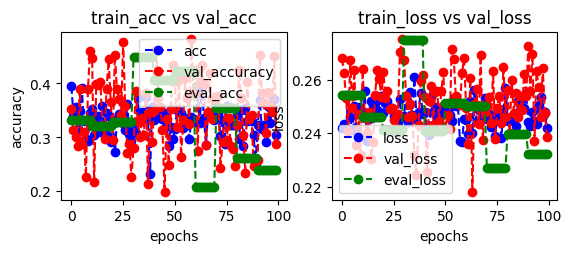

In [17]:
def plot_accuracy_loss(history):
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'],'ro--', label = "val_accuracy")
    plt.plot(accuracy_list,'go--', label = "eval_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'],'ro--', label = "val_loss")
    plt.plot(evaluation_list,'go--', label = "eval_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.savefig("ExampleImages/sdg_simple.png")
plot_accuracy_loss(history)